In [1]:
from syndat import SynDat
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import json

In [2]:
# create test df with continuous, categorical, and time vars
n = 10000
x_norm = np.random.randn(n)
x_unif = np.random.rand(n)
x_categ = np.random.choice(['c1','c2','c3'], size=n, p=[0.2,0.3,0.5])
x_date = np.random.permutation(
    pd.date_range('2000-01-01', '2020-01-01', periods=n)
)

df = pd.DataFrame(
    {'x_norm':x_norm, 'x_unif':x_unif, 'x_categ':x_categ, 'x_date':x_date}
)

cols = {'x_norm':'quant', 'x_unif':'quant', 'x_categ':'categ', 'x_date':'dt'}
# allowed types: quant, categ, ord, dt
# cols should be entered in order
# dicts are insertion order in python 3.6+

df.head()

,x_norm,x_unif,x_categ,x_date
0,0.429214,0.602121,c2,2005-01-19 10:15:39.693969408
1,2.162561,0.091623,c2,2016-01-19 20:22:15.013501376
2,0.864776,0.644498,c1,2016-08-07 18:09:10.855085568
3,-0.869036,0.586230,c2,2019-01-19 17:00:03.240324096
4,0.923974,0.623682,c3,2005-08-14 04:18:47.632763296


In [3]:
sd = SynDat(df, cols)

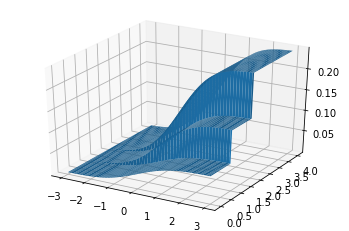

In [4]:
# plot mixture of continuous and categorical - CDF
x=np.linspace(-3,3,100)
y=np.linspace(0,4,100)
X, Y = np.meshgrid(x,y)
x_unif_samp = 0.5
x_date_samp = np.median(df['x_date'])
z = np.array([sd.kde.cdf([x,x_unif_samp,y,x_date_samp]) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = z.reshape(X.shape)

ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,Z)

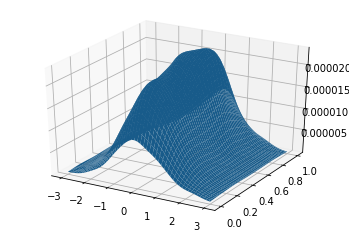

In [6]:
# plot continuous vars - PDF
x=np.linspace(-3,3,100)
y=np.linspace(0,1,100)
X, Y = np.meshgrid(x,y)

x_categ_samp = 2
x_date_samp = np.median(df['x_date'])
z = np.array([sd.kde.pdf([x,y,x_categ_samp,x_date_samp]) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = z.reshape(X.shape)

ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,Z)

In [7]:
# get synthetic data
df_samp = sd.get_sample(n=1000)

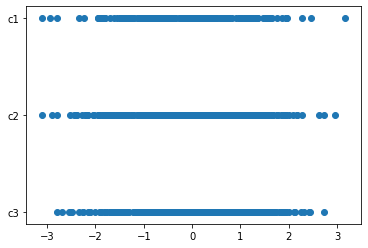

In [8]:
# plot sampled data - normal vs categorical
ax = plt.axes()
ax.scatter(df_samp['x_norm'],df_samp['x_categ'])

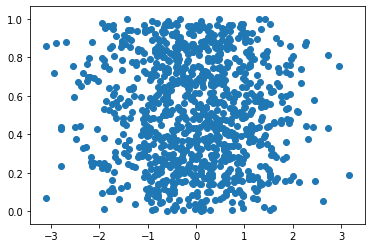

In [9]:
# plot sampled data - normal vs uniform
ax = plt.axes()
ax.scatter(df_samp['x_norm'],df_samp['x_unif'])

In [10]:
# save data to files
import json
df.to_csv('samp_dat.csv', index=False)

with open('samp_cols.json', 'w') as fid:
    json.dump(cols, fid)
